<img src='../img/acam_logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='65%'></img>

<br>

# 1.5 MLS/Aura Level 3 Monthly Binned Carbon Monoxide (CO)

###  Fire Monitoring - October 2015 - Indonesian Fires

The [Microwave Limb Sounder (MLS)](https://disc.gsfc.nasa.gov/information/data-release?title=New%20MLS%20v4.2%20Level%203%20Gridded%20Data%20Products%20Released ) is an instrument onboard the Earth Observing System (EOS) Aura spacecraft. It measures naturally-occurring microwave thermal emission from the limb (edge) of Earth's atmosphere to remotely sense vertical profiles of atmospheric gases, temperature, pressure, and cloud ice. 

MLS data are distributed via:
- the [NASA Goddard Space Flight Center Earth Science Data and Information Services Center (GES-DISC)](https://disc.gsfc.nasa.gov/).

MLS Level 3 data are geophysical products that are binned onto regular grids. They are disseminated in `netCDF` format. You can learn more about the MLS data products by reading the [MLS v4 Data Quality Document](https://mls.jpl.nasa.gov/data/v4-2_data_quality_document.pdf). For this case study, we will be using the monthly binned dataset.

#### Indonesian Fires 2015

In 2015, devastating wildfires in Indonesia broke out. As reported by [Reuters](https://www.reuters.com/article/us-indonesia-politics-haze-analysis-idUSKCN1UV0ZJ), "Between June and October that year, about 2.6 million hectares (6.4 million acres) of land burned in Indonesia, mainly on Sumatra and Borneo islands, said a 2016 World Bank report. A Harvard University study linked the 2015 haze to more than 100,000 premature deaths in Indonesia, Malaysia and Singapore."

#### This module has the following outline:
* [1 - Load and browse MLS CO Level 3 data](#load)
* [2 - Visualize MLS CO Level 3 data](#visualize)

#### Load required libraries

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb

from netCDF4 import Dataset
import pandas as pd


from matplotlib import animation

from IPython.display import HTML
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#### Load helper functions

In [21]:
%run ../functions.ipynb

<hr>

## <a id="load"></a>Load and browse MLS CO Level 3 product

You can use the Python library [xarray](http://xarray.pydata.org/en/stable/index.html) to access and manipulate datasets in `netCDF` format.

The following examples shows an example of `Carbon monoxide (CO)`.

### Load netCDF data with `xarray`

Each MLS Monthly Binned Level 3 file is organised in six groups:

- `<product> PressureGrid`: 4°×5° geodetic longitude/latitude grid on pressure surfaces
- `<product> ThetaGrid`: 4°×5° geodetic longitude/latitude grid on potential temperature surfaces
- `<product> PressureZM`: 4° geodetic latitude zonal mean on pressure surfaces
- `<product> ThetaZM`: 4° geodetic latitude zonal mean on potential temperature surfaces
- `<product> EqlZM`: 4° equivalent latitude zonal mean on potential temperature surfaces
- `<product> VortexAvg`: Polar vortex average values for each hemisphere on potential temperature surfaces.

`xarray`'s function `open_dataset` enables you to open a `netCDF` file. Once loaded, you can inspect the data structure of the `MLS Level 3` data disseminated by the GES-DISC. In order to load the variable as part of the MLS Daily Binned Level 3 file, you have to specify the following keyword arguments, replacing `<product>` with the product name, e.g. `CO`: 
- `group='CO PressureGrid'`: to load the `CO PressureGrid` group

#### <a id='step1'></a>Load the MLS Level 3 data

In [22]:
file_name_co = '../eodata/mls/ML3MBCO/2015/10/MLS-Aura_L3MB-CO_v04-23-c01_2015.nc'
file_co = xr.open_dataset(file_name_co, group='CO PressureGrid')
file_co

<xarray.Dataset>
Dimensions:          (lat: 45, lev: 37, lon: 72, nv: 2, time: 12)
Coordinates:
  * lon              (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * lat              (lat) float32 -88.0 -84.0 -80.0 -76.0 ... 80.0 84.0 88.0
  * time             (time) datetime64[ns] 2015-01-15 2015-02-15 ... 2015-12-15
  * lev              (lev) float32 1000.0 681.29205 ... 2.1544347e-05 1e-05
Dimensions without coordinates: nv
Data variables:
    lon_bnds         (lon, nv) float32 ...
    lat_bnds         (lat, nv) float32 ...
    time_bnds        (time, nv) datetime64[ns] ...
    value            (time, lev, lon, lat) float32 ...
    rms_uncertainty  (time, lev, lon, lat) float32 ...
    minimum          (time, lev, lon, lat) float32 ...
    maximum          (time, lev, lon, lat) float32 ...
    std_dev          (time, lev, lon, lat) float32 ...
    nvalues          (time, lev, lon, lat) float64 ...
Attributes:
    VerticalCoordinate:   Pressure
    LatLonGridType:       Geodetic
    LatitudeResolution:   4.0
    LongitudeResolution:  5.0
    DataSubset:           None

MLS `<product> PressureGrid` and `<product> ThetaGrid` product groups have four **dimensions**:
* `lon`: the longitude at center of the grid cell 
* `lat`: the latitude at center of the grid cell
* `time`: the date of the grid cell
* `lev`: the vertical coordinate (i.e. pressure/potential temperature values)

You see that the loaded data object also contains nine **data variables**:
* `lon_bnds`: the longitude at the boundaries of the grid cell
* `lat_bnds`: the latitude at the boundaries of the grid cell
* `time_bnds`: the boundaries of the time period
* `value`: the average value for each bin
* `rms_uncertainty`: the root mean square of all the Level 2 L2GPPrecision values that contributed to each bin (note that this has not been divided by √nvalues)
* `minimum`: the minimum value in each bin
* `maximum`: the maximum value in each bin
* `std_dev`: the standard deviation of the data in each bin
* `nvalues`: the number of valid data points found in each bin


If you examine the `time` coordinate, you will notice that the dataset has 12 timesteps, one for each month in 2015.

### Retrieve the variable `value` as xarray.DataArray

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `value` is the 'Average Value of Carbon Monoxide', has the unit `vmr` and has four dimensions, `time`, `lev`, `lon` and `lat` respectively. Note that `vmr` stands for volume mixing ratio.

In [23]:
co = file_co['value']
co

<xarray.DataArray 'value' (time: 12, lev: 37, lon: 72, lat: 45)>
[1438560 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
  * time     (time) datetime64[ns] 2015-01-15 2015-02-15 ... 2015-12-15
  * lev      (lev) float32 1000.0 681.29205 464.15887 ... 2.1544347e-05 1e-05
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

You can retrieve the array values of the variable with squared brackets: `[:,:,:,:]`, which corresponds to the dimensions in this order: `[time, lev, lon, lat]`. One single time step can be selected by specifying one value of the `time` dimension, e.g. `[9,:,:,:]`. This corresponds to selecting the data for the `October 2015`.

In [24]:
co_day = co[9,:,:,:]
co_day

<xarray.DataArray 'value' (lev: 37, lon: 72, lat: 45)>
[119880 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2015-10-15
  * lev      (lev) float32 1000.0 681.29205 464.15887 ... 2.1544347e-05 1e-05
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

Now, we want to retrieve the data at two levels: `100 hPa` and `215 hPa`. 

You can retrieve the array values of the variable with squared brackets: `[:,:,:]`, which corresponds to the dimensions in this order: `[lev, lon, lat]`. One level can be selected by specifying one value of the `lev` dimension, e.g. `[6,:,:]`. This corresponds to selecting the data for `100 hPa`.

In [25]:
co_100hpa = co_day[6,:,:]
co_100hpa

<xarray.DataArray 'value' (lon: 72, lat: 45)>
array([[         nan,          nan, 1.979388e-08, ..., 4.034055e-08,
                 nan,          nan],
       [         nan,          nan, 2.174052e-08, ..., 3.970144e-08,
                 nan,          nan],
       [         nan,          nan, 2.359576e-08, ..., 3.993457e-08,
                 nan,          nan],
       ...,
       [         nan,          nan, 2.447751e-08, ..., 3.729527e-08,
                 nan,          nan],
       [         nan,          nan, 2.208649e-08, ..., 3.735501e-08,
                 nan,          nan],
       [         nan,          nan, 2.298443e-08, ..., 3.866612e-08,
                 nan,          nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2015-10-15
    lev      float32 100.0
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

Next, you can retrieve the data at `215 hPa`. 

In [26]:
co_215hpa = co_day[4,:,:]
co_215hpa

<xarray.DataArray 'value' (lon: 72, lat: 45)>
array([[         nan,          nan, 3.271283e-08, ..., 5.549372e-08,
                 nan,          nan],
       [         nan,          nan, 2.872609e-08, ..., 5.264822e-08,
                 nan,          nan],
       [         nan,          nan, 3.276605e-08, ..., 5.144506e-08,
                 nan,          nan],
       ...,
       [         nan,          nan, 3.232931e-08, ..., 5.436158e-08,
                 nan,          nan],
       [         nan,          nan, 3.383997e-08, ..., 5.748037e-08,
                 nan,          nan],
       [         nan,          nan, 3.058961e-08, ..., 5.196665e-08,
                 nan,          nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2015-10-15
    lev      float32 215.44347
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

To do this in a single step, we can use `[9,6,:,:]` for `100 hPa` and `[9,4,:,:]` for `215 hPa`.

In [27]:
co_100hpa = co[9,6,:,:]
co_100hpa

<xarray.DataArray 'value' (lon: 72, lat: 45)>
array([[         nan,          nan, 1.979388e-08, ..., 4.034055e-08,
                 nan,          nan],
       [         nan,          nan, 2.174052e-08, ..., 3.970144e-08,
                 nan,          nan],
       [         nan,          nan, 2.359576e-08, ..., 3.993457e-08,
                 nan,          nan],
       ...,
       [         nan,          nan, 2.447751e-08, ..., 3.729527e-08,
                 nan,          nan],
       [         nan,          nan, 2.208649e-08, ..., 3.735501e-08,
                 nan,          nan],
       [         nan,          nan, 2.298443e-08, ..., 3.866612e-08,
                 nan,          nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2015-10-15
    lev      float32 100.0
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

In [28]:
co_215hpa = co[9,4,:,:]
co_215hpa

<xarray.DataArray 'value' (lon: 72, lat: 45)>
array([[         nan,          nan, 3.271283e-08, ..., 5.549372e-08,
                 nan,          nan],
       [         nan,          nan, 2.872609e-08, ..., 5.264822e-08,
                 nan,          nan],
       [         nan,          nan, 3.276605e-08, ..., 5.144506e-08,
                 nan,          nan],
       ...,
       [         nan,          nan, 3.232931e-08, ..., 5.436158e-08,
                 nan,          nan],
       [         nan,          nan, 3.383997e-08, ..., 5.748037e-08,
                 nan,          nan],
       [         nan,          nan, 3.058961e-08, ..., 5.196665e-08,
                 nan,          nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -88.0 -84.0 -80.0 -76.0 -72.0 ... 76.0 80.0 84.0 88.0
    time     datetime64[ns] 2015-10-15
    lev      float32 215.44347
Attributes:
    long_name:  Average Value of Carbon Monoxide
    units:      vmr
    comments:   The average value in a bin

##  <a id="visualize"></a>Visualize the MLS CO Level 3 data

#### Visualize the data array in an `Orthographic()` projection with the function `visualize_pcolormesh`

The final step is to visualize the gridded data with the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh).

The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`

We need to transpose the dataset using `xarray.DataArray.transpose` in order to plot the data array.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Average Value of Carbon Monoxide (100 hPa) for 2015-10-15'}>)

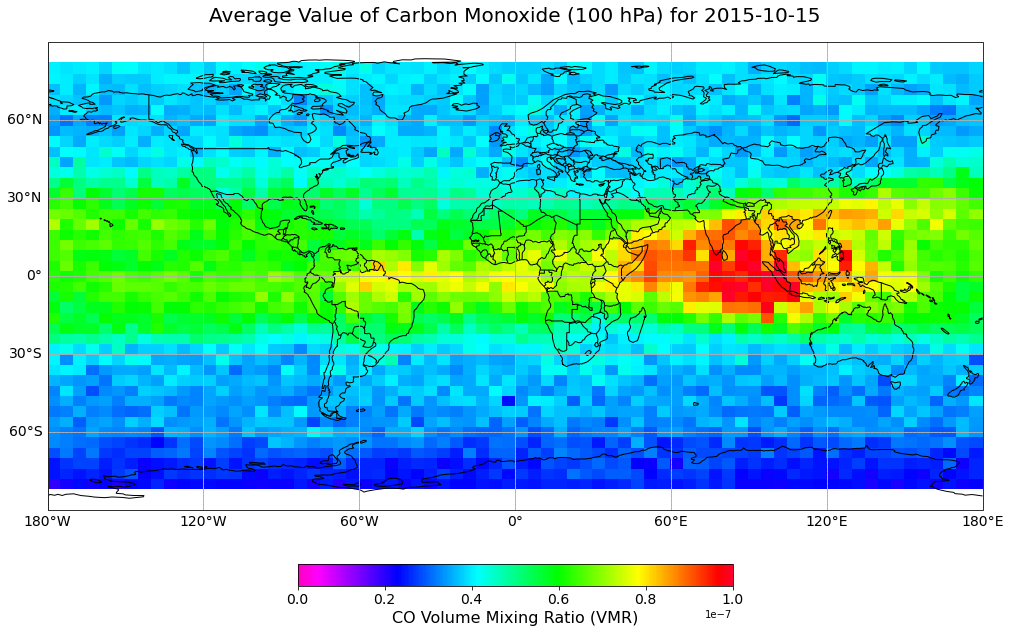

In [29]:
visualize_pcolormesh(data_array=co_100hpa.transpose(), 
                     longitude=co_100hpa.lon, 
                     latitude=co_100hpa.lat, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='gist_rainbow_r', 
                     unit='CO Volume Mixing Ratio (VMR)', 
                     long_name=co_100hpa.long_name + ' (100 hPa) for ' + str(co_100hpa.time.data)[0:10], 
                     vmin=0, 
                     vmax=1e-07)

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Average Value of Carbon Monoxide (215 hPa) for 2015-10-15'}>)

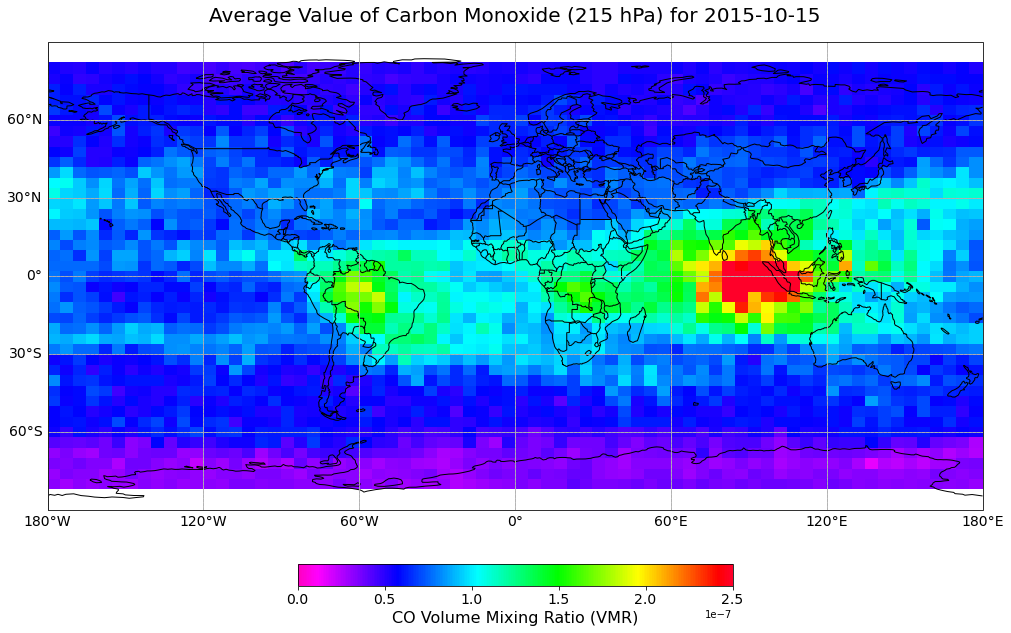

In [30]:
visualize_pcolormesh(data_array=co_215hpa.transpose(), 
                     longitude=co_215hpa.lon, 
                     latitude=co_215hpa.lat, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='gist_rainbow_r', 
                     unit='CO Volume Mixing Ratio (VMR)', 
                     long_name=co_215hpa.long_name + ' (215 hPa) for ' + str(co_215hpa.time.data)[0:10], 
                     vmin=0, 
                     vmax=2.5e-07)

<br>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="../LICENSE">MIT License</a> and is developed under a Copernicus contract.